gerar a matriz de projeto, de acordo com o problema que vamos tratar

montar as euqações normais

solucionar o sistema de equações fazendo ou nao regularização

padronização

lambda*|w|^2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def train_test_split(X, y, test_size=0.2, seed=7, shuffle=True):
  n=len(y)
  idx=  np.arange(n)  #array de indices
  if shuffle:
    rng = np.random.default_rng(seed)
    rng.shuffle(idx) # embaralha os indices
  nte = int(round(test_size*n))
  te = idx[:nte]  # seleciona n*test_size indices
  tr= idx[nte:]   # seleciona os n*(1-test_size) indices restantes para treino
  return X[tr], y[tr], X[te], y[te]   # retorna o conjunto de x
                                    # de treino, y de treino, x de teste e y de teste


#idx = [2 3 1 5 7 8 9 0 6 4]
#X= [1 3 6 1 392 382 303 3 30 39]
#te = [2 3]
#tr = [1 5 7 8 9 0 6 4]

#X[te] = [6 1]
#X[tr] = [1 3 392 382 303 3 30 39]

#y = [132 313 0 7 1.6 6.8 1303 33 30 39]
#y[te] = [7 1.6]
#y[tr] = [132 313 0 6.8 1303 33 30 39]




In [3]:
X = np.array([[1, 3], [2, 5], [3, 8], [4, 9], [5, 3], [6, 2]])
#X = [1   3
#     2   5
#     3   8
#     4   9
#     5   3
#     6   2
#     ]

In [4]:
def matriz_de_projeto(X, grau=2): # define a matriz que gera o modelo que vai ajustar os dados
  X= np.asarray(X, dtype=float)
  n=X.shape[0]
  cols=[np.ones((n,1))]
  for j in range (X.shape[1]):
    xj= X[:,j:j+1]
    for d in range(1,grau+1):
      cols.append(xj**d)
  return np.hstack(cols)

def padronizar_treino(X):     # padroniza os parametros
                              #de ajuste subtraindo a média e
                              #dividindo pelo desvio padrão
  X= np.asarray(X, dtype=float)
  Xp=X.copy()

  mi = X[:,1:].mean(axis=0)
  std = X[:,1:].std(axis=0, ddof=0)
  std=np.where(std==0,  1, std)
  Xp[:,1:] = (Xp[:,1:]-mi)/std
  return Xp, mi, std

def padronizar_teste(X, mi, std): # Usa os valores que padronizaram o treino
                                # para padronizar o teste

  X= np.asarray(X, dtype=float)
  Xp=X.copy()
  Xp[:,1:] = (Xp[:,1:]-mi)/std
  return Xp


def ridge(X, y, lam=0):
  # (XT@X - I0*lam )* w = XT@y  -> w= inv(XT@X) * XT@y
  # X  = 40x2 XT = 2X40    2x40 @ 40x2 = 2x2
  XTX = X.T @ X
  I0= np.eye(XTX.shape[1])
  I0[0,0] = 0
  return np.linalg.solve(XTX + lam*I0, X.T @ y)
  #  XTX + lam*I0

# [ 0 1 | 2 3 |  4 5  | 6 7     8 9 ]

def kfolds_idx(n, k=5, seed=42, shuffle=True):
  idx=  np.arange(n)
  if shuffle:
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
  return np.array_split(idx, k)

def rmse(yv, yp):
  return float(np.sqrt(np.mean((yv-yp)**2)))

def cv_grid(X , y , graus, lambdas, k= 5, seed =42, padronizar = True):
  s = kfolds_idx(len(y), k, seed)
  results=[]
  for d in graus:
    for lam in lambdas:
      rmses = []
      for f in range(k):
        va=s[f]
        tr= np.concatenate([s[i] for i in range(k) if i!=f])
        Xtr = matriz_de_projeto(X[tr], d)
        Xva = matriz_de_projeto(X[va], d)
        ytr = y[tr]
        yva = y[va]
        if padronizar:
          Xtr_p, mi, std = padronizar_treino(Xtr)
          Xva_p = padronizar_teste(Xva, mi, std)
        else:
          Xtr_p = Xtr
          Xva_p = Xva
        w = ridge(Xtr_p, ytr, lam)
        yp = Xva_p @ w
        rmses.append(rmse(yva,yp))

      mediarmse= float(np.mean(rmses))
      results.append((mediarmse, float(np.std(rmses)),d , float(lam)))
  best = min(results, key= lambda x: x[0])
  return results, best

#f=1
#[1 2; 3 4; 5 6; 7 8; 9 10]
# va = [3 4]
# tr = [1 2 5 6 7 8 9 10]


In [5]:
#df = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv')
df = pd.read_csv('poly_curve.csv')
df = pd.read_csv('ads_sales.csv')

In [6]:
X_bruto = df[["TV","Radio","Social"]].to_numpy()
y_bruto = df[["Sales"]].to_numpy()

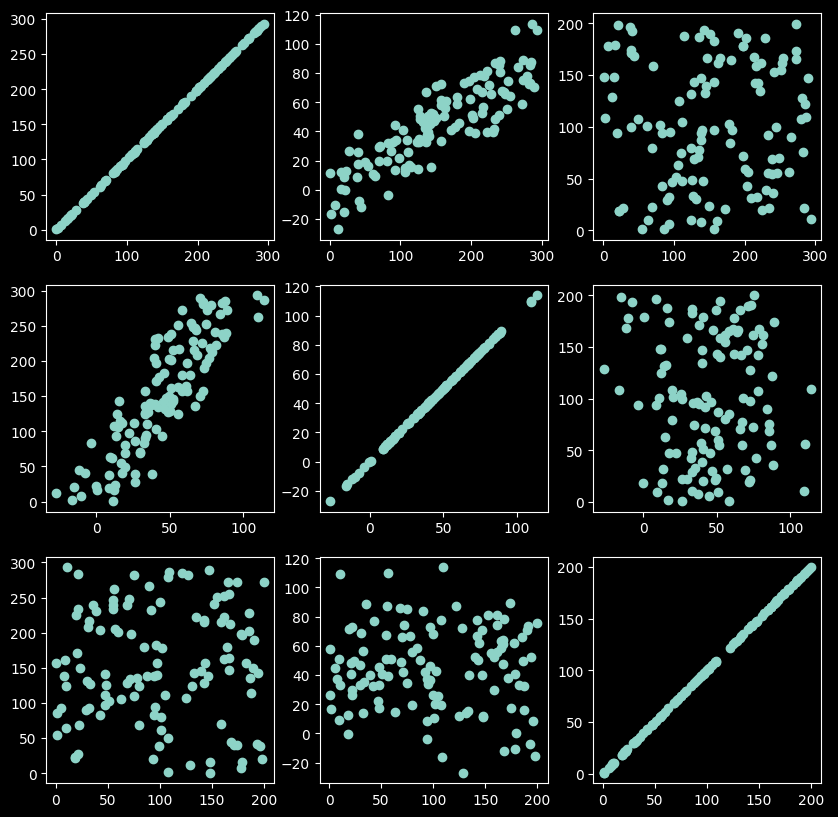

In [7]:
fig, axes = plt.subplots(X_bruto.shape[1],X_bruto.shape[1],figsize=(10,10))
for i in range(X_bruto.shape[1]):
  for j in range(X_bruto.shape[1]):
    axes[i,j].scatter(X_bruto[:,i], X_bruto[:,j])

In [8]:
mx = matriz_de_projeto(X_bruto,2)

print(mx[:10])

[[ 1.00000000e+00  2.28924868e+01  5.24065952e+02  1.27409314e+01
   1.62331334e+02  1.85163606e+01  3.42855611e+02]
 [ 1.00000000e+00  2.33975638e+02  5.47445990e+04  4.85458664e+01
   2.35670115e+03  2.12118436e+01  4.49942309e+02]
 [ 1.00000000e+00  1.31522769e+02  1.72982389e+04  4.67518588e+01
   2.18573630e+03  2.98449901e+01  8.90723436e+02]
 [ 1.00000000e+00  2.17039553e+02  4.71061677e+04  5.65697819e+01
   3.20014023e+03  3.22400018e+01  1.03941772e+03]
 [ 1.00000000e+00  2.93396854e+02  8.60817137e+04  1.09419873e+02
   1.19727087e+04  1.05511586e+01  1.11326948e+02]
 [ 1.00000000e+00  1.61548761e+02  2.60980022e+04  5.08172881e+01
   2.58239677e+03  9.40263301e+00  8.84095075e+01]
 [ 1.00000000e+00  1.50336139e+02  2.26009547e+04  7.08667925e+01
   5.02210228e+03  1.89685659e+02  3.59806493e+04]
 [ 1.00000000e+00  2.16153400e+01  4.67222924e+02 -3.87299891e-01
   1.50001206e-01  1.82583580e+01  3.33367637e+02]
 [ 1.00000000e+00  8.05316940e+01  6.48535374e+03  1.98397502e+0

In [9]:
Xbruto = df[["x"]].to_numpy()
ybruto = df[["y"]].to_numpy()

KeyError: "None of [Index(['x'], dtype='object')] are in the [columns]"

In [ ]:
graus = [1, 2, 3, 4, 5, 6]
lambdas = np.logspace(-4,2,11)

Xtrb, ytr, Xteb, yte = train_test_split(Xbruto, ybruto, test_size=0.2)

print(Xtrb.shape, ytr.shape, Xteb.shape, yte.shape)
print(lambdas)

(112, 1) (112, 1) (28, 1) (28, 1)
[1.00000000e-04 3.98107171e-04 1.58489319e-03 6.30957344e-03
 2.51188643e-02 1.00000000e-01 3.98107171e-01 1.58489319e+00
 6.30957344e+00 2.51188643e+01 1.00000000e+02]


In [ ]:
res, best = cv_grid(Xtrb, ytr, graus, lambdas, k= 5, seed =42, padronizar = True)


best

(1.9624452088488131, 0.1923568490648764, 3, 0.0001)

In [ ]:
best_mean, best_std, grau, lam = best

Xtr= matriz_de_projeto(Xtrb, grau)
Xte= matriz_de_projeto(Xteb, grau)

Xtr_p , mi, std = padronizar_treino(Xtr)
Xte_p = padronizar_teste(Xte, mi, std)

w = ridge(Xtr_p, ytr, lam)
yp = Xte_p @ w

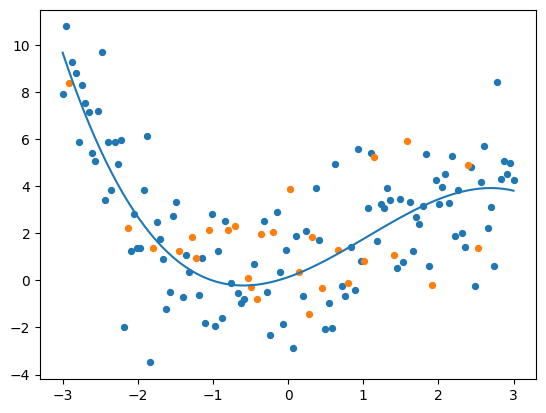

In [ ]:
plt.figure()
s= np.linspace(Xbruto.min(), Xbruto.max(), 100).reshape(-1,1)
xs= matriz_de_projeto(s, 3)

xsp= padronizar_teste(xs,mi, std)
yp= xsp @ w

plt.scatter(Xtrb, ytr, s=18)
plt.scatter(Xteb, yte, s=18)
plt.plot(s, yp)

plt.show()

In [ ]:
matriz_de_projeto(X)

# y = w0 +w1*x1 +w2*x1^2 + w3*x2 +w4*x2^2

array([[ 1.,  1.,  1.,  3.,  9.],
       [ 1.,  2.,  4.,  5., 25.],
       [ 1.,  3.,  9.,  8., 64.],
       [ 1.,  4., 16.,  9., 81.],
       [ 1.,  5., 25.,  3.,  9.],
       [ 1.,  6., 36.,  2.,  4.]])